<a href="https://colab.research.google.com/github/RochaErik/AlgorithmComparison/blob/main/AlgorithmComparison3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **Evaluating algorithms with hyperparameter tuning**

---

In [109]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [111]:
!pip install hyperopt

In [112]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# **Wine Dataset**

In [113]:
wine_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Wine\wine.data', header=None)

In [114]:
X = wine_df.iloc[:, 1:]
y = wine_df.iloc[:, 0]

In [115]:
le = LabelEncoder()
y = le.fit_transform(y)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  2%|▏         | 1/50 [00:00<00:11,  4.18trial/s, best loss: -0.9722222222222222]

100%|██████████| 50/50 [00:26<00:00,  1.90trial/s, best loss: -1.0]              
Best hyperparameters for AdaBoost:
{'n_estimators': 200.0, 'learning_rate': 0.06659352635164861, 'max_depth': 4.0, 'max_features': 'sqrt', 'min_samples_leaf': 3.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [01:14<00:00,  1.49s/trial, best loss: -1.0]              
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04102652661864284, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [02:39<00:00,  3.19s/trial, best loss: -1.0]
Best hyperparameters for CatBoost:
{'n_estimators': 550, 'learning_rate': 0.0479901225935416, 'min_child_samples': 1, 'max_depth': 6, 'reg_lambda': 3.3766279624518107, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [00:01<00:00, 33.8

In [118]:
best_hyperparams['AdaBoost']

{'n_estimators': 200.0,
 'learning_rate': 0.06659352635164861,
 'max_depth': 4.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 3.0,
 'min_samples_split': 2.0,
 'random_state': 42}

In [119]:
best_hyperparams['GradBoost']

{'criterion': 'friedman_mse',
 'max_features': 'sqrt',
 'n_estimators': 100,
 'learning_rate': 0.04102652661864284,
 'max_depth': 3,
 'min_samples_split': 7,
 'min_samples_leaf': 7,
 'min_weight_fraction_leaf': 0.0,
 'min_impurity_decrease': 1.0,
 'ccp_alpha': 0.0,
 'random_state': 42}

In [120]:
best_hyperparams['CatBoost']

{'n_estimators': 550,
 'learning_rate': 0.0479901225935416,
 'min_child_samples': 1,
 'max_depth': 6,
 'reg_lambda': 3.3766279624518107,
 'silent': True,
 'random_state': 42}

In [121]:
best_hyperparams['LightGBM']

{'class_weight': 'balanced',
 'boosting_type': 'gbdt',
 'num_leaves': 55,
 'learning_rate': 0.04496177447997528,
 'min_child_samples': 10,
 'reg_alpha': 0.3916912792044354,
 'reg_lambda': 1.4941077467431771,
 'colsample_by_tree': 0.379259630420579,
 'verbosity': -1,
 'random_state': 42}

In [122]:
best_hyperparams['XGBoost']

{'booster': 'dart',
 'learning_rate': 0.09292666170093178,
 'gamma': 4,
 'max_depth': 4,
 'min_child_weight': 1,
 'colsample_bytree': 0.8943278668489419,
 'colsample_bylevel': 0.2640104690942444,
 'colsample_bynode': 0.8937107554719765,
 'reg_alpha': 0.056770729092546546,
 'reg_lambda': 4.219736540591216,
 'random_state': 42}

In [123]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [124]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [125]:
wine_scores = []
wine_scores_mean = []
wine_scores_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    wine_scores.append(results)
    wine_scores_mean.append(results.mean()*100)
    wine_scores_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Wine Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Wine Dataset ---------
[0.94444444 0.94444444 0.94444444 1.         0.94444444 1.
 1.         0.83333333 1.         1.         1.         1.
 0.94444444 1.         0.94444444 1.         1.         0.88888889
 1.         0.94117647 1.         1.         0.88888889 0.94444444
 1.         1.         1.         1.         0.88235294 1.
 0.94444444 1.         1.         0.94444444 1.         0.94444444
 1.         1.         0.94117647 0.88235294 0.88888889 1.
 1.         0.94444444 1.         1.         1.         1.
 0.82352941 0.94117647 1.         0.94444444 1.         0.94444444
 1.         1.         0.94444444 0.94444444 0.94117647 0.94117647
 1.         1.         0.94444444 1.         1.         0.88888889
 0.94444444 0.94444444 0.88235294 1.         0.94444444 1.
 1.         0.94444444 1.         1.         0.94444444 0.94444444
 0.94117647 0.94117647 1.         1.         1.         0.94444444
 1.         0.94444444 0.94444444 1.         0.94117647 1.
 0.944

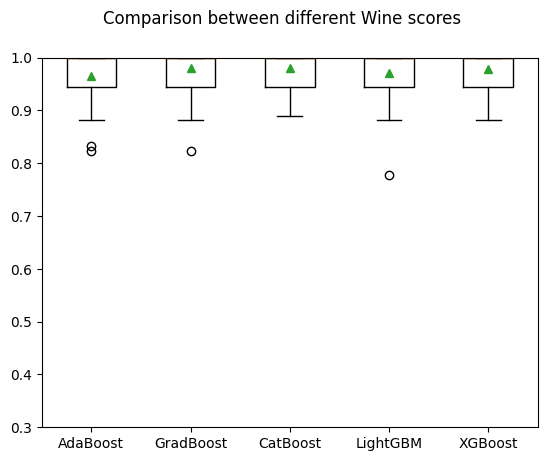

In [126]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Wine scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(wine_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [127]:
Algo_results = pd.DataFrame()
Algo_results['Names'] = names

In [128]:
Algo_results['Wine'] = wine_scores_mean

In [129]:
Algo_results

,Names,Wine
0,AdaBoost,96.552288
1,GradBoost,98.075163
2,CatBoost,97.967320
3,LightGBM,97.120915
4,XGBoost,97.797386


---

# **Breast Cancer Dataset**

---

In [130]:
breast_cancer_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\BreastCancer\Breast.dat', sep=',', header=None)

In [131]:
X = breast_cancer_df.iloc[:, :-1]
y = breast_cancer_df.iloc[:, -1]

In [132]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:44<00:00,  1.12trial/s, best loss: -0.9927007299270073]
Best hyperparameters for AdaBoost:
{'n_estimators': 450.0, 'learning_rate': 0.01199453123793802, 'max_depth': 4.0, 'max_features': 'log2', 'min_samples_leaf': 4.0, 'min_samples_split': 6.0, 'random_state': 42}
100%|██████████| 50/50 [00:18<00:00,  2.67trial/s, best loss: -0.9927007299270073]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 550, 'learning_rate': 0.0611622198189229, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:40<00:00,  1.23trial/s, best loss: -0.9927007299270073]
Best hyperparameters for CatBoost:
{'n_estimators': 300, 'learning_rate': 0.013094250183297027, 'min_child_samples': 1, 'max_depth': 5, 'reg_lambda': 4.710165866797953, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [

In [135]:
best_hyperparams['AdaBoost']

{'n_estimators': 450.0,
 'learning_rate': 0.01199453123793802,
 'max_depth': 4.0,
 'max_features': 'log2',
 'min_samples_leaf': 4.0,
 'min_samples_split': 6.0,
 'random_state': 42}

In [ ]:
best_hyperparams['GradBoost']

In [ ]:
best_hyperparams['CatBoost']

In [ ]:
best_hyperparams['LightGBM']

In [ ]:
best_hyperparams['XGBoost']

In [136]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [137]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [138]:
breast_cancer_scores = []
breast_cancer_mean = []
breast_cancer_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    breast_cancer_scores.append(results)
    breast_cancer_mean.append(results.mean()*100)
    breast_cancer_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Breast Cancer Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Breast Cancer Dataset ---------
[0.95652174 0.97101449 0.92753623 0.95588235 0.97058824 1.
 0.97058824 0.97058824 0.98529412 0.98529412 0.97101449 0.95652174
 0.95652174 0.98529412 0.95588235 0.95588235 1.         0.97058824
 0.98529412 0.97058824 1.         0.95652174 0.97101449 0.98529412
 0.95588235 0.98529412 0.97058824 0.98529412 0.97058824 0.97058824
 0.98550725 0.94202899 0.98550725 0.97058824 0.98529412 1.
 0.97058824 0.98529412 0.94117647 0.95588235 0.95652174 0.98550725
 0.98550725 1.         0.98529412 0.97058824 0.97058824 0.98529412
 0.95588235 0.94117647 0.98550725 0.92753623 1.         1.
 0.94117647 0.98529412 0.97058824 0.98529412 0.97058824 0.97058824
 0.95652174 0.98550725 0.98550725 0.91176471 0.98529412 0.98529412
 0.94117647 0.97058824 0.92647059 1.         0.95652174 1.
 0.97101449 0.95588235 0.98529412 0.94117647 0.98529412 0.98529412
 0.95588235 0.97058824 0.97101449 0.97101449 0.97101449 0.97058824
 0.98529412 0.95588235 0.97058824 0.9705

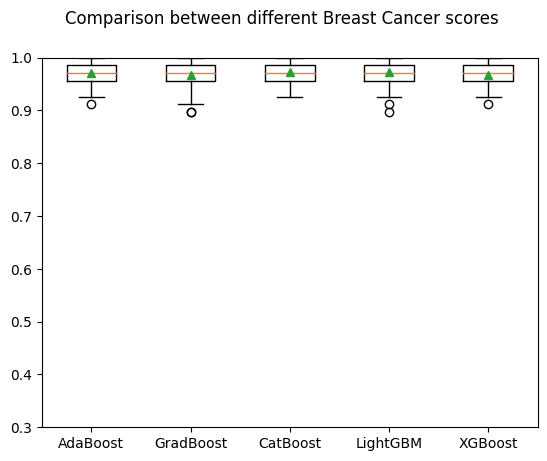

In [139]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Breast Cancer scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(breast_cancer_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [140]:
Algo_results['Breast_Cancer'] = breast_cancer_mean

In [141]:
Algo_results

,Names,Wine,Breast_Cancer
0,AdaBoost,96.552288,97.159847
1,GradBoost,98.075163,96.646633
2,CatBoost,97.967320,97.378303
3,LightGBM,97.120915,97.334612
4,XGBoost,97.797386,96.792626


---

# **Sonar Dataset** #

---

In [142]:
sonar_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Sonar\Sonar.csv', header=None)

In [143]:
X = sonar_df.iloc[:, :-1]
y = sonar_df.iloc[:, -1]

In [144]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

100%|██████████| 50/50 [02:46<00:00,  3.34s/trial, best loss: -0.9523809523809523]
Best hyperparameters for AdaBoost:
{'n_estimators': 1250.0, 'learning_rate': 0.011066661922600281, 'max_depth': 2.0, 'max_features': None, 'min_samples_leaf': 5.0, 'min_samples_split': 6.0, 'random_state': 42}
100%|██████████| 50/50 [00:55<00:00,  1.12s/trial, best loss: -0.8571428571428571]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04102652661864284, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 1.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [05:28<00:00,  6.57s/trial, best loss: -0.8809523809523809]
Best hyperparameters for CatBoost:
{'n_estimators': 1300, 'learning_rate': 0.014023863721779927, 'min_child_samples': 9, 'max_depth': 7, 'reg_lambda': 0.2645130637158699, 'silent': True, 'random_state': 42}
100%|██████████| 50/5

In [147]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [148]:
best_hyperparams['AdaBoost']

{'n_estimators': 1250.0,
 'learning_rate': 0.011066661922600281,
 'max_depth': 2.0,
 'max_features': None,
 'min_samples_leaf': 5.0,
 'min_samples_split': 6.0,
 'random_state': 42}

In [ ]:
best_hyperparams['GradBoost']

In [ ]:
best_hyperparams['CatBoost']

In [ ]:
best_hyperparams['LightGBM']

In [ ]:
best_hyperparams['XGBoost']

In [149]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [150]:
sonar_scores = []
sonar_mean = []
sonar_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    sonar_scores.append(results)
    sonar_mean.append(results.mean()*100)
    sonar_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Sonar Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Sonar Dataset ---------
[0.95238095 0.80952381 0.85714286 0.95238095 0.80952381 1.
 0.9047619  0.85714286 0.85       1.         0.9047619  0.9047619
 0.95238095 0.9047619  0.80952381 0.9047619  0.9047619  0.9047619
 0.85       0.75       0.76190476 0.80952381 1.         0.9047619
 0.80952381 0.9047619  0.85714286 0.76190476 0.85       0.9
 0.95238095 0.85714286 0.9047619  0.71428571 0.85714286 0.80952381
 0.80952381 0.9047619  0.85       0.8        0.9047619  0.76190476
 0.9047619  0.71428571 0.76190476 0.85714286 0.80952381 0.71428571
 0.9        0.95       0.9047619  0.85714286 0.85714286 0.85714286
 0.80952381 0.9047619  0.95238095 0.9047619  0.9        0.8
 0.66666667 0.85714286 0.9047619  0.9047619  0.76190476 0.9047619
 0.80952381 0.9047619  0.65       1.         0.85714286 0.9047619
 0.80952381 0.9047619  0.95238095 0.76190476 0.9047619  0.85714286
 0.85       0.9        0.76190476 0.76190476 0.76190476 1.
 0.95238095 0.95238095 0.9047619  0.9047619  0.9   

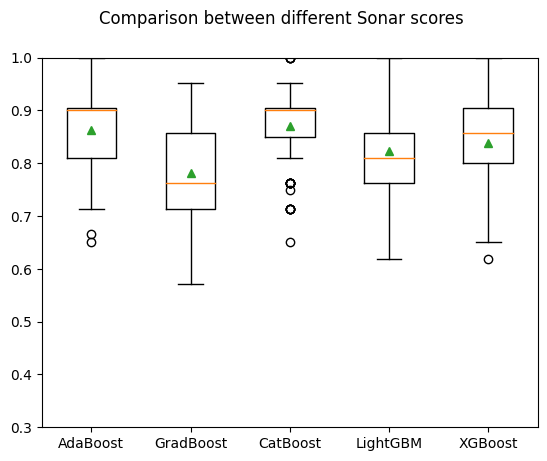

In [151]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Sonar scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(sonar_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [152]:
Algo_results['Sonar'] = sonar_mean

In [153]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar
0,AdaBoost,96.552288,97.159847,86.347619
1,GradBoost,98.075163,96.646633,78.145238
2,CatBoost,97.967320,97.378303,87.076190
3,LightGBM,97.120915,97.334612,82.361905
4,XGBoost,97.797386,96.792626,83.802381


---

# **Ionosphere Dataset**

---

In [154]:
ionosphere_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Ionosphere\ionosphere.data', header=None)

In [155]:
ionosphere_df.shape

(351, 35)

In [156]:
X = ionosphere_df.iloc[:, :-1]
y = ionosphere_df.iloc[:, -1]

In [157]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [160]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [161]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:28<00:00,  1.77s/trial, best loss: -0.971830985915493] 
Best hyperparameters for AdaBoost:
{'n_estimators': 50.0, 'learning_rate': 0.046035205781861564, 'max_depth': 6.0, 'max_features': 'log2', 'min_samples_leaf': 5.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [00:55<00:00,  1.11s/trial, best loss: -0.9295774647887324]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 400, 'learning_rate': 0.021178191623985942, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 2.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [07:12<00:00,  8.65s/trial, best loss: -0.9577464788732394]
Best hyperparameters for CatBoost:
{'n_estimators': 750, 'learning_rate': 0.02983152512960275, 'min_child_samples': 3, 'max_depth': 5, 'reg_lambda': 3.8771604915102147, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 [

In [162]:
ionosphere_scores = []
ionosphere_mean = []
ionosphere_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    ionosphere_scores.append(results)
    ionosphere_mean.append(results.mean()*100)
    ionosphere_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Ionosphere Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Ionosphere Dataset ---------
[1.         0.91428571 0.91428571 0.94285714 0.97142857 0.91428571
 0.94285714 0.97142857 0.97142857 0.88571429 0.97222222 0.94285714
 0.97142857 0.97142857 1.         0.94285714 0.91428571 0.88571429
 0.91428571 0.88571429 0.86111111 0.85714286 0.97142857 0.94285714
 0.97142857 0.94285714 1.         0.94285714 0.88571429 1.
 0.91666667 0.97142857 0.94285714 1.         0.91428571 0.91428571
 0.85714286 0.91428571 0.94285714 0.88571429 0.97222222 1.
 0.91428571 0.91428571 0.97142857 0.82857143 1.         0.97142857
 0.91428571 0.85714286 0.94444444 0.97142857 0.91428571 1.
 0.94285714 0.97142857 0.97142857 0.91428571 0.91428571 0.88571429
 0.97222222 0.91428571 0.91428571 0.94285714 0.97142857 0.91428571
 1.         0.88571429 1.         0.94285714 0.97222222 0.88571429
 0.91428571 0.94285714 0.88571429 0.88571429 1.         0.91428571
 0.97142857 1.         0.91666667 0.94285714 0.94285714 0.97142857
 0.8        1.         0.91428571 1

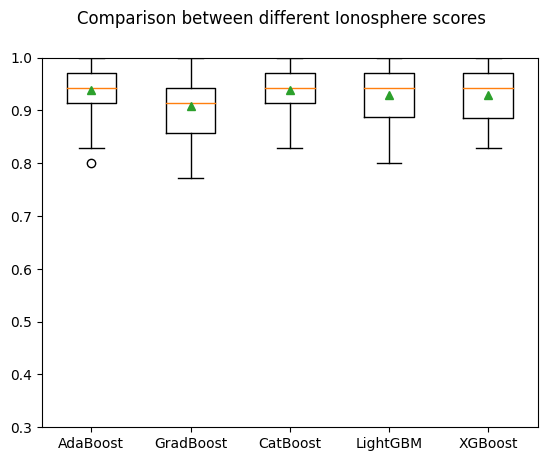

In [163]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Ionosphere scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(ionosphere_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [164]:
Algo_results['Ionosphere'] = ionosphere_mean

In [165]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere
0,AdaBoost,96.552288,97.159847,86.347619,93.815873
1,GradBoost,98.075163,96.646633,78.145238,90.854762
2,CatBoost,97.967320,97.378303,87.076190,93.815079
3,LightGBM,97.120915,97.334612,82.361905,92.849206
4,XGBoost,97.797386,96.792626,83.802381,92.960317


---

# **Tic-Tac-Toe Dataset**

---

In [167]:
tictactoe_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\TicTacToe\TicTacToe.data', header=None)

In [168]:
dummies = {
            'x': 0,
            'o': 1,
            'b': 2,
          }
tictactoe_df = tictactoe_df.iloc[:, 0: 9].replace(dummies)

In [169]:
X = tictactoe_df.iloc[:, :-1]
y = tictactoe_df.iloc[:, -1]

In [170]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  2%|▏         | 1/50 [00:01<01:32,  1.89s/trial, best loss: -0.4895833333333333]

100%|██████████| 50/50 [01:10<00:00,  1.42s/trial, best loss: -0.8125]            
Best hyperparameters for AdaBoost:
{'n_estimators': 1200.0, 'learning_rate': 0.06916005440000361, 'max_depth': 2.0, 'max_features': None, 'min_samples_leaf': 4.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [01:13<00:00,  1.47s/trial, best loss: -0.8177083333333334]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 850, 'learning_rate': 0.09835742587463962, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [00:35<00:00,  1.40trial/s, best loss: -0.71875]           
Best hyperparameters for CatBoost:
{'n_estimators': 1350, 'learning_rate': 0.052871577465477125, 'min_child_samples': 9, 'max_depth': 1, 'reg_lambda': 3.1381917920726017, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 

In [173]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [174]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [175]:
tictactoe_scores = []
tictactoe_mean = []
tictactoe_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    tictactoe_scores.append(results)
    tictactoe_mean.append(results.mean()*100)
    tictactoe_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on TicTacToe Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on TicTacToe Dataset ---------
[0.875      0.88541667 0.77083333 0.82291667 0.875      0.73958333
 0.84375    0.79166667 0.84210526 0.78947368 0.79166667 0.8125
 0.76041667 0.84375    0.78125    0.8125     0.8125     0.85416667
 0.78947368 0.82105263 0.83333333 0.78125    0.75       0.85416667
 0.90625    0.80208333 0.89583333 0.79166667 0.83157895 0.8
 0.80208333 0.84375    0.85416667 0.84375    0.76041667 0.77083333
 0.79166667 0.77083333 0.87368421 0.77894737 0.80208333 0.79166667
 0.76041667 0.73958333 0.75       0.78125    0.875      0.83333333
 0.83157895 0.86315789 0.80208333 0.80208333 0.80208333 0.80208333
 0.8125     0.80208333 0.82291667 0.82291667 0.78947368 0.81052632
 0.85416667 0.80208333 0.83333333 0.75       0.80208333 0.88541667
 0.77083333 0.78125    0.78947368 0.78947368 0.80208333 0.80208333
 0.73958333 0.79166667 0.85416667 0.84375    0.84375    0.75
 0.8        0.85263158 0.72916667 0.84375    0.79166667 0.84375
 0.8125     0.92708333 0.8229166

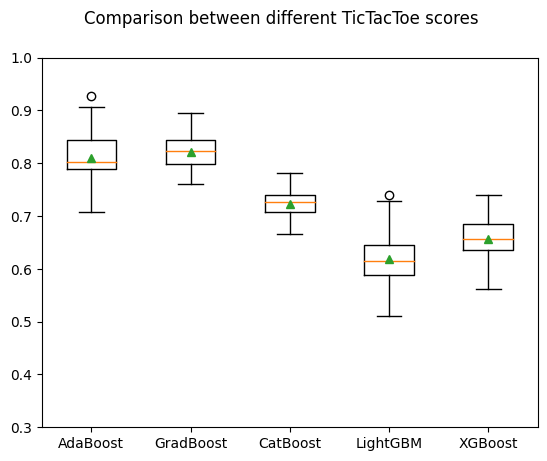

In [176]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different TicTacToe scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(tictactoe_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [177]:
Algo_results['TicTacToe'] = tictactoe_mean

In [178]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053


---

# **Bupa**

---

In [179]:
bupa_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Bupa\Bupa.data', header=None)

In [180]:
bupa_df.shape

(345, 7)

In [181]:
X = bupa_df.iloc[:, :-1]
y = bupa_df.iloc[:, -1]

In [182]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:07<00:00,  1.35s/trial, best loss: -0.8695652173913043]
Best hyperparameters for AdaBoost:
{'n_estimators': 1150.0, 'learning_rate': 0.036566586849114326, 'max_depth': 6.0, 'max_features': 'sqrt', 'min_samples_leaf': 3.0, 'min_samples_split': 2.0, 'random_state': 42}
100%|██████████| 50/50 [00:19<00:00,  2.54trial/s, best loss: -0.8115942028985508]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': None, 'n_estimators': 650, 'learning_rate': 0.06856648459048352, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:02<00:00,  1.25s/trial, best loss: -0.7971014492753623]
Best hyperparameters for CatBoost:
{'n_estimators': 1000, 'learning_rate': 0.07885766008379519, 'min_child_samples': 8, 'max_depth': 2, 'reg_lambda': 2.215819236413667, 'silent': True, 'random_state': 42}
100%|██████████| 50/50

In [185]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [186]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [187]:
bupa_scores = []
bupa_mean = []
bupa_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    bupa_scores.append(results)
    bupa_mean.append(results.mean()*100)
    bupa_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Bupa Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Bupa Dataset ---------
[0.77142857 0.74285714 0.71428571 0.71428571 0.77142857 0.88235294
 0.67647059 0.64705882 0.67647059 0.61764706 0.65714286 0.57142857
 0.68571429 0.8        0.68571429 0.70588235 0.70588235 0.76470588
 0.73529412 0.67647059 0.65714286 0.71428571 0.8        0.74285714
 0.77142857 0.70588235 0.79411765 0.73529412 0.70588235 0.67647059
 0.77142857 0.77142857 0.74285714 0.82857143 0.74285714 0.79411765
 0.64705882 0.70588235 0.70588235 0.67647059 0.74285714 0.8
 0.65714286 0.68571429 0.77142857 0.73529412 0.73529412 0.64705882
 0.67647059 0.70588235 0.65714286 0.77142857 0.74285714 0.62857143
 0.77142857 0.70588235 0.70588235 0.70588235 0.58823529 0.58823529
 0.74285714 0.77142857 0.6        0.57142857 0.68571429 0.73529412
 0.61764706 0.82352941 0.85294118 0.67647059 0.8        0.65714286
 0.82857143 0.74285714 0.65714286 0.79411765 0.76470588 0.70588235
 0.67647059 0.73529412 0.8        0.68571429 0.71428571 0.82857143
 0.68571429 0.70588235 0

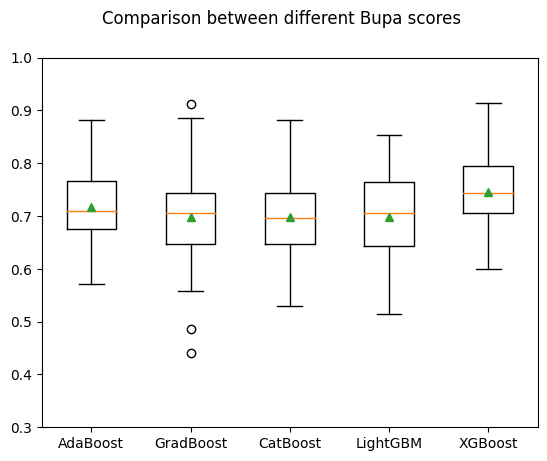

In [188]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Bupa scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(bupa_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [189]:
Algo_results['Bupa'] = bupa_mean

In [190]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630


---

# **Pima**

---

In [191]:
pima_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Pima\Diabetes.csv')

In [192]:
pima_df.shape

(768, 9)

In [193]:
X = pima_df.iloc[:, :-1]
y = pima_df.iloc[:, -1]

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [195]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:36<00:00,  1.94s/trial, best loss: -0.7857142857142857]
Best hyperparameters for AdaBoost:
{'n_estimators': 1500.0, 'learning_rate': 0.010436960322525368, 'max_depth': 1.0, 'max_features': None, 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [00:24<00:00,  2.00trial/s, best loss: -0.7922077922077922]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 200, 'learning_rate': 0.05871692740564188, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 2.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:13<00:00,  1.46s/trial, best loss: -0.7792207792207793]
Best hyperparameters for CatBoost:
{'n_estimators': 50, 'learning_rate': 0.010922414344918462, 'min_child_samples': 10, 'max_depth': 4, 'reg_lambda': 4.685483905860218, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 

In [196]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [197]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [198]:
pima_scores = []
pima_mean = []
pima_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    pima_scores.append(results)
    pima_mean.append(results.mean()*100)
    pima_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Pima Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Pima Dataset ---------
[0.80519481 0.76623377 0.75324675 0.85714286 0.81818182 0.74025974
 0.74025974 0.71428571 0.75       0.69736842 0.77922078 0.7012987
 0.75324675 0.74025974 0.74025974 0.84415584 0.80519481 0.72727273
 0.73684211 0.82894737 0.81818182 0.74025974 0.77922078 0.68831169
 0.75324675 0.76623377 0.74025974 0.81818182 0.71052632 0.69736842
 0.80519481 0.75324675 0.76623377 0.77922078 0.79220779 0.74025974
 0.77922078 0.80519481 0.76315789 0.67105263 0.76623377 0.77922078
 0.84415584 0.81818182 0.80519481 0.75324675 0.68831169 0.77922078
 0.73684211 0.69736842 0.76623377 0.77922078 0.76623377 0.72727273
 0.76623377 0.80519481 0.71428571 0.74025974 0.76315789 0.72368421
 0.76623377 0.74025974 0.75324675 0.76623377 0.71428571 0.83116883
 0.74025974 0.74025974 0.76315789 0.75       0.80519481 0.75324675
 0.72727273 0.84415584 0.74025974 0.74025974 0.77922078 0.72727273
 0.75       0.73684211 0.72727273 0.72727273 0.79220779 0.79220779
 0.77922078 0.8181

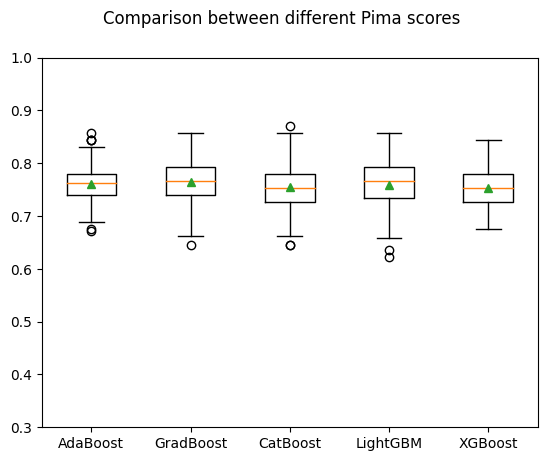

In [199]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Pima scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(pima_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [200]:
Algo_results['Pima'] = pima_mean

In [201]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748,76.101504
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193,76.426863
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218,75.527683
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118,75.920711
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630,75.334074


---

# **Heart**

---

In [202]:
heart_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Heart\Heart.csv')

In [203]:
X = heart_df.iloc[:, :-1]
y = heart_df.iloc[:, -1]

In [204]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [205]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:36<00:00,  1.93s/trial, best loss: -0.7857142857142857]
Best hyperparameters for AdaBoost:
{'n_estimators': 1500.0, 'learning_rate': 0.010436960322525368, 'max_depth': 1.0, 'max_features': None, 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [00:24<00:00,  2.02trial/s, best loss: -0.7922077922077922]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 200, 'learning_rate': 0.05871692740564188, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 2.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:11<00:00,  1.42s/trial, best loss: -0.7792207792207793]
Best hyperparameters for CatBoost:
{'n_estimators': 50, 'learning_rate': 0.010922414344918462, 'min_child_samples': 10, 'max_depth': 4, 'reg_lambda': 4.685483905860218, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 

In [206]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [207]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [208]:
heart_scores = []
heart_mean = []
heart_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    heart_scores.append(results)
    heart_mean.append(results.mean()*100)
    heart_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Heart Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Heart Dataset ---------
[0.81481481 0.81481481 0.81481481 0.96296296 0.77777778 0.85185185
 0.88888889 0.77777778 0.81481481 0.96296296 0.85185185 0.77777778
 0.88888889 0.81481481 0.88888889 0.85185185 0.96296296 0.66666667
 0.81481481 0.85185185 0.77777778 0.96296296 0.81481481 0.74074074
 0.96296296 0.81481481 0.81481481 0.74074074 0.81481481 0.92592593
 0.81481481 0.88888889 0.85185185 0.81481481 0.81481481 0.88888889
 0.81481481 0.77777778 0.85185185 0.81481481 0.81481481 0.96296296
 0.74074074 0.88888889 0.7037037  0.88888889 0.77777778 0.88888889
 0.77777778 0.88888889 0.66666667 0.81481481 0.85185185 0.85185185
 0.77777778 0.88888889 0.85185185 0.81481481 0.81481481 0.85185185
 0.85185185 0.88888889 0.85185185 0.88888889 0.85185185 0.77777778
 0.85185185 0.74074074 0.77777778 0.92592593 0.88888889 0.85185185
 0.77777778 0.88888889 0.81481481 0.88888889 0.77777778 0.88888889
 0.81481481 0.85185185 0.92592593 0.85185185 0.85185185 0.85185185
 0.74074074 0.81

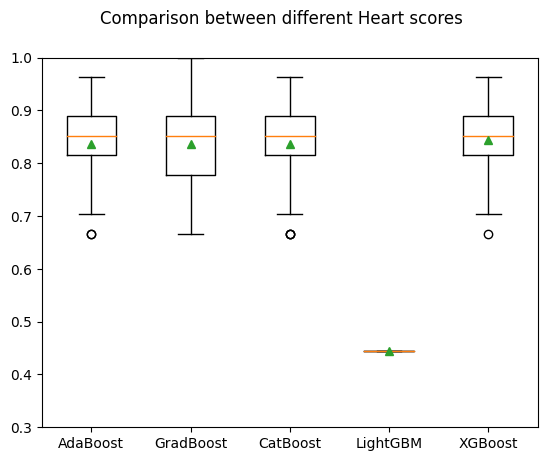

In [209]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Heart scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(heart_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [210]:
Algo_results['Heart'] = heart_mean

In [211]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima,Heart
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748,76.101504,83.592593
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193,76.426863,83.703704
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218,75.527683,83.740741
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118,75.920711,44.444444
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630,75.334074,84.444444


---

# **Liver**

---

In [213]:
liver_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Liver\Bupa.data', header=None)

In [214]:
X = liver_df.iloc[:, :-1]
y = liver_df.iloc[:, -1]

In [215]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [216]:
from hyperopt.pyll import scope
import warnings

# Filter out the FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

best_hyperparams = {
    'AdaBoost': {},
    'GradBoost': {},
    'CatBoost': {},
    'LightGBM': {},
    'XGBoost': {}
}

# Define the hyperparameter search space for each algorithm

def optimize_adaboost(params):
    estimator_params = params['estimator']
    estimator = DecisionTreeClassifier(**estimator_params)

    clf = AdaBoostClassifier(estimator=estimator, n_estimators=params['n_estimators'], learning_rate=params['learning_rate'], random_state=params['random_state'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_gradientboost(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_catboost(params):
    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_lightgbm(params):
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

def optimize_xgboost(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return -accuracy_score(y_test, y_pred)

# Define the hyperparameter search space for each algorithm

max_features_choices = [None, 'sqrt', 'log2']
space_adaboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'estimator': {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),  # Decision tree depth
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 8, 2)),  # Min samples required to split
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),  # Min samples required in a leaf node
        'max_features': hp.choice('max_features', max_features_choices),
    },
    'random_state': 42
}

criterion_choices = ['friedman_mse', 'squared_error']
max_features_choices = [None, 'sqrt', 'log2']
space_gradientboost = {
    'criterion': hp.choice('criterion', criterion_choices),
    'max_features': hp.choice('max_features', max_features_choices),
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.5, 0.1),
    'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 5, 1),
    'ccp_alpha': hp.quniform('ccp_alpha', 0.0, 5, 1),
    'random_state': 42
}

space_catboost = {
    'n_estimators': 1 + scope.int(hp.quniform('n_estimators', 5, 1500, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'silent': True
}

class_weight_choices = ['balanced']
boosting_type_choices = ['gbdt', 'dart', 'goss']
space_lightgbm = {
    'class_weight': hp.choice('class_weight', class_weight_choices),                                              
    'boosting_type': hp.choice('boosting_type', boosting_type_choices),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 200, 10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.1, 1.0),
    'verbosity': -1,
    'random_state': 42
}

booster_choices = ['gbtree', 'dart']
space_xgboost = {
    'booster': hp.choice('booster', booster_choices),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma': scope.int(hp.quniform('gamma', 0, 10, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 6, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 6, 1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5.0),
    'verbosity': 0,
    'random_state': 42
}

# Define optimization functions and algorithm names
optimizers = [
    (optimize_adaboost, space_adaboost, 'AdaBoost'),
    (optimize_gradientboost, space_gradientboost, 'GradBoost'),
    (optimize_catboost, space_catboost, 'CatBoost'),
    (optimize_lightgbm, space_lightgbm, 'LightGBM'),
    (optimize_xgboost, space_xgboost, 'XGBoost')
]


# Performing hyperparameter tuning for each algorithm

rstate=np.random.default_rng(42)

for optimize_fn, space, algorithm_name in optimizers:
    if algorithm_name == 'AdaBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        max_features_label = max_features_choices[best['max_features']]

        # Store the best AdaBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': best['n_estimators'],
            'learning_rate': best['learning_rate'],
            'max_depth': best['max_depth'],
            'max_features': max_features_label,
            'min_samples_leaf': best['min_samples_leaf'],
            'min_samples_split': best['min_samples_split'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'GradBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)


        # Map the choice labels        
        criterion_label = criterion_choices[best['criterion']]
        max_features_label = max_features_choices[best['max_features']]

        # Store the best GradBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'criterion': criterion_label,
            'max_features': max_features_label,
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'max_depth': int(best['max_depth']),
            'min_samples_split': int(best['min_samples_split']),
            'min_samples_leaf': int(best['min_samples_leaf']),
            'min_weight_fraction_leaf': best['min_weight_fraction_leaf'],
            'min_impurity_decrease': best['min_impurity_decrease'],
            'ccp_alpha': best['ccp_alpha'],
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])           
    
    if algorithm_name == 'CatBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Store the best CatBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'n_estimators': int(best['n_estimators']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'max_depth': int(best['max_depth']),
            'reg_lambda': best['reg_lambda'],
            'silent': True,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'LightGBM':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        class_weight_label = class_weight_choices[best['class_weight']]
        boosting_type_label = boosting_type_choices[best['boosting_type']]

        # Store the best LightGBM hyperparameters
        best_hyperparams[algorithm_name] = {
            'class_weight': class_weight_label,
            'boosting_type': boosting_type_label,
            'num_leaves': int(best['num_leaves']),
            'learning_rate': best['learning_rate'],
            'min_child_samples': int(best['min_child_samples']),
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],
            'colsample_by_tree': best['colsample_by_tree'],
            'verbosity': -1,
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

    if algorithm_name == 'XGBoost':
        trials = Trials()
        best = fmin(fn=optimize_fn, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)
        
        # Map the choice labels
        booster_label = booster_choices[best['booster']]        
 
        # Store the best XGBoost hyperparameters
        best_hyperparams[algorithm_name] = {
            'booster': booster_label,
            'learning_rate': best['learning_rate'],
            'gamma': int(best['gamma']),
            'max_depth': int(best['max_depth']),
            'min_child_weight': int(best['min_child_weight']),
            'colsample_bytree': best['colsample_bytree'],
            'colsample_bylevel': best['colsample_bylevel'],
            'colsample_bynode': best['colsample_bynode'],            
            'reg_alpha': best['reg_alpha'],
            'reg_lambda': best['reg_lambda'],            
            'random_state': 42
        }

        print(f"Best hyperparameters for {algorithm_name}:")
        print(best_hyperparams[algorithm_name])

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:39<00:00,  2.00s/trial, best loss: -0.7857142857142857]
Best hyperparameters for AdaBoost:
{'n_estimators': 1500.0, 'learning_rate': 0.010436960322525368, 'max_depth': 1.0, 'max_features': None, 'min_samples_leaf': 5.0, 'min_samples_split': 4.0, 'random_state': 42}
100%|██████████| 50/50 [00:25<00:00,  1.94trial/s, best loss: -0.7922077922077922]
Best hyperparameters for GradBoost:
{'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 200, 'learning_rate': 0.05871692740564188, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'min_impurity_decrease': 2.0, 'ccp_alpha': 0.0, 'random_state': 42}
100%|██████████| 50/50 [01:13<00:00,  1.47s/trial, best loss: -0.7792207792207793]
Best hyperparameters for CatBoost:
{'n_estimators': 50, 'learning_rate': 0.010922414344918462, 'min_child_samples': 10, 'max_depth': 4, 'reg_lambda': 4.685483905860218, 'silent': True, 'random_state': 42}
100%|██████████| 50/50 

In [217]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [218]:
names = ['AdaBoost', 'GradBoost', 'CatBoost', 'LightGBM', 'XGBoost']

In [219]:
liver_scores = []
liver_mean = []
liver_std = []
model_names = []

for algorithm_name in names:
    if algorithm_name == 'AdaBoost':
        base_estimator = DecisionTreeClassifier(max_depth=int(best_hyperparams[algorithm_name]['max_depth']),
                                                max_features=best_hyperparams[algorithm_name]['max_features'],
                                                min_samples_leaf=int(best_hyperparams[algorithm_name]['min_samples_leaf']),
                                                min_samples_split=int(best_hyperparams[algorithm_name]['min_samples_split']))

        clf = AdaBoostClassifier(estimator=base_estimator, 
                                n_estimators=int(best_hyperparams[algorithm_name]['n_estimators']), 
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                random_state=42)    

    if algorithm_name == 'GradBoost':
        clf = GradientBoostingClassifier(criterion=best_hyperparams[algorithm_name]['criterion'], 
                                        max_features=best_hyperparams[algorithm_name]['max_features'], 
                                        n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                        learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                        max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                        min_samples_split=best_hyperparams[algorithm_name]['min_samples_split'],
                                        min_samples_leaf=best_hyperparams[algorithm_name]['min_samples_leaf'],
                                        min_weight_fraction_leaf=best_hyperparams[algorithm_name]['min_weight_fraction_leaf'],
                                        min_impurity_decrease=best_hyperparams[algorithm_name]['min_impurity_decrease'],
                                        ccp_alpha=best_hyperparams[algorithm_name]['ccp_alpha'],
                                        random_state=42)
         
    if algorithm_name == 'CatBoost':
        clf = CatBoostClassifier(n_estimators=best_hyperparams[algorithm_name]['n_estimators'],
                                learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                                min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                                max_depth=best_hyperparams[algorithm_name]['max_depth'],
                                reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                                silent=True,
                                random_state=42)                        
        
    if algorithm_name == 'LightGBM':
        clf = LGBMClassifier(boosting_type=best_hyperparams[algorithm_name]['boosting_type'], 
                            class_weight=best_hyperparams[algorithm_name]['class_weight'], 
                            colsample_by_tree=best_hyperparams[algorithm_name]['colsample_by_tree'],
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            min_child_samples=best_hyperparams[algorithm_name]['min_child_samples'],
                            num_leaves=best_hyperparams[algorithm_name]['num_leaves'],
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=-1,
                            random_state=42)
               
    if algorithm_name == 'XGBoost':
        clf = XGBClassifier(booster=best_hyperparams[algorithm_name]['booster'], 
                            learning_rate=best_hyperparams[algorithm_name]['learning_rate'],
                            gamma=best_hyperparams[algorithm_name]['gamma'], 
                            max_depth=best_hyperparams[algorithm_name]['max_depth'], 
                            min_child_weight=best_hyperparams[algorithm_name]['min_child_weight'],
                            colsample_bytree=best_hyperparams[algorithm_name]['colsample_bytree'],
                            colsample_bylevel=best_hyperparams[algorithm_name]['colsample_bylevel'],
                            colsample_bynode=best_hyperparams[algorithm_name]['colsample_bynode'],                            
                            reg_alpha=best_hyperparams[algorithm_name]['reg_alpha'],
                            reg_lambda=best_hyperparams[algorithm_name]['reg_lambda'],
                            verbosity=0,
                            random_state=42)
        
    results = cross_val_score(clf, X, y, cv=rskf)
    liver_scores.append(results)
    liver_mean.append(results.mean()*100)
    liver_std.append(results.std()*100)
    model_names.append(algorithm_name)
    print(f'--------- {algorithm_name} on Liver Dataset ---------')
    print(results)
    print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
    print('------------------------------')

--------- AdaBoost on Liver Dataset ---------
[0.91428571 0.8        0.62857143 0.77142857 0.62857143 0.85294118
 0.79411765 0.61764706 0.64705882 0.70588235 0.77142857 0.65714286
 0.62857143 0.8        0.8        0.70588235 0.76470588 0.64705882
 0.70588235 0.76470588 0.62857143 0.54285714 0.77142857 0.8
 0.8        0.85294118 0.79411765 0.58823529 0.67647059 0.70588235
 0.8        0.77142857 0.71428571 0.85714286 0.74285714 0.76470588
 0.64705882 0.70588235 0.70588235 0.64705882 0.65714286 0.74285714
 0.68571429 0.57142857 0.8        0.73529412 0.76470588 0.67647059
 0.70588235 0.76470588 0.71428571 0.74285714 0.74285714 0.65714286
 0.74285714 0.76470588 0.76470588 0.82352941 0.70588235 0.64705882
 0.68571429 0.88571429 0.62857143 0.68571429 0.71428571 0.67647059
 0.70588235 0.79411765 0.76470588 0.61764706 0.82857143 0.6
 0.8        0.77142857 0.77142857 0.82352941 0.76470588 0.64705882
 0.70588235 0.67647059 0.65714286 0.74285714 0.77142857 0.8
 0.74285714 0.73529412 0.76470588 0.6

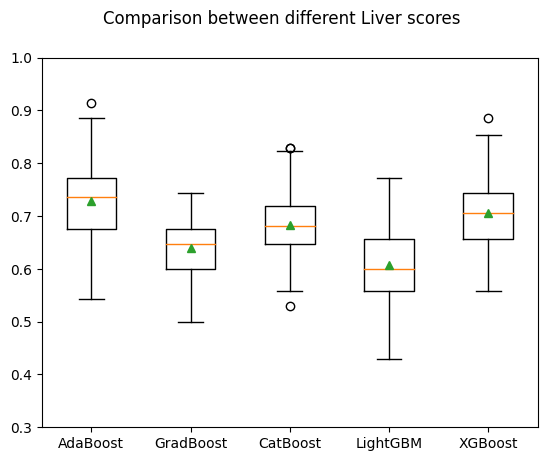

In [220]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Liver scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(liver_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [221]:
Algo_results['Liver'] = liver_mean

In [222]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima,Heart,Liver
0,AdaBoost,96.552288,97.159847,86.347619,93.815873,81.054167,71.669748,76.101504,83.592593,72.778151
1,GradBoost,98.075163,96.646633,78.145238,90.854762,82.224232,69.783193,76.426863,83.703704,63.923529
2,CatBoost,97.967320,97.378303,87.076190,93.815079,72.318311,69.846218,75.527683,83.740741,68.334454
3,LightGBM,97.120915,97.334612,82.361905,92.849206,61.814474,69.794118,75.920711,44.444444,60.722689
4,XGBoost,97.797386,96.792626,83.802381,92.960317,65.721053,74.475630,75.334074,84.444444,70.573109


In [223]:
Tuned_Algo_results_tr = Algo_results.set_index('Names').T

In [224]:
Tuned_Algo_results_tr.to_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\TunedAlgoResults.csv', index=False)

In [225]:
Tuned_Algo_results_tr

Names,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
Wine,96.552288,98.075163,97.967320,97.120915,97.797386
Breast_Cancer,97.159847,96.646633,97.378303,97.334612,96.792626
Sonar,86.347619,78.145238,87.076190,82.361905,83.802381
Ionosphere,93.815873,90.854762,93.815079,92.849206,92.960317
TicTacToe,81.054167,82.224232,72.318311,61.814474,65.721053
Bupa,71.669748,69.783193,69.846218,69.794118,74.475630
Pima,76.101504,76.426863,75.527683,75.920711,75.334074
Heart,83.592593,83.703704,83.740741,44.444444,84.444444
Liver,72.778151,63.923529,68.334454,60.722689,70.573109


---

# **Friedman's Test**

---

In [226]:
!pip install scikit-posthocs

     ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
      --------------------------------------- 0.1/9.4 MB 2.8 MB/s eta 0:00:04
     -- ------------------------------------- 0.6/9.4 MB 7.1 MB/s eta 0:00:02
     ---- ----------------------------------- 1.0/9.4 MB 8.3 MB/s eta 0:00:02
     ---- ----------------------------------- 1.0/9.4 MB 8.3 MB/s eta 0:00:02
     ---- ----------------------------------- 1.0/9.4 MB 8.3 MB/s eta 0:00:02
     --------- ------------------------------ 2.2/9.4 MB 8.3 MB/s eta 0:00:01
     ----------------- ---------------------- 4.2/9.4 MB 13.3 MB/s eta 0:00:01
     ----------------- ---------------------- 4.2/9.4 MB 13.3 MB/s eta 0:00:01
     ---------------------- ----------------- 5.4/9.4 MB 13.2 MB/s eta 0:00:01
     -------------------------------------- - 8.9/9.4 MB 19.7 MB/s eta 0:00:01
     ---------------------------------------- 9.4/9.4 MB 19.3 MB/s eta 0:00:00
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)


In [227]:
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

In [228]:
Tuned_Algo_results_tr = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\TunedAlgoResults.csv')

In [229]:
Tuned_Algo_results_tr

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,96.552288,98.075163,97.967320,97.120915,97.797386
1,97.159847,96.646633,97.378303,97.334612,96.792626
2,86.347619,78.145238,87.076190,82.361905,83.802381
3,93.815873,90.854762,93.815079,92.849206,92.960317
4,81.054167,82.224232,72.318311,61.814474,65.721053
5,71.669748,69.783193,69.846218,69.794118,74.475630
6,76.101504,76.426863,75.527683,75.920711,75.334074
7,83.592593,83.703704,83.740741,44.444444,84.444444
8,72.778151,63.923529,68.334454,60.722689,70.573109


In [230]:
stat, p_value = friedmanchisquare(Tuned_Algo_results_tr['AdaBoost'], Tuned_Algo_results_tr['GradBoost'], Tuned_Algo_results_tr['CatBoost'], Tuned_Algo_results_tr['LightGBM'], Tuned_Algo_results_tr['XGBoost'])

In [231]:
p_value

0.149383786120395

In [232]:
alpha = 0.05
if p_value < alpha:
    print('There are significant differences among the models.')
else:
    print('There are no significant differences among the models.')

There are no significant differences among the models.


---

# **Nemenyi test**

---

In [233]:
nemenyi_results = sp.posthoc_nemenyi_friedman(a=Tuned_Algo_results_tr)

In [234]:
nemenyi_results

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
AdaBoost,1.000000,0.728536,0.900000,0.225673,0.900000
GradBoost,0.728536,1.000000,0.643932,0.897740,0.900000
CatBoost,0.900000,0.643932,1.000000,0.166548,0.900000
LightGBM,0.225673,0.897740,0.166548,1.000000,0.559331
XGBoost,0.900000,0.900000,0.900000,0.559331,1.000000


In [235]:
alpha = 0.05

# Print p-values for all pairs of models
for i in range(nemenyi_results.shape[0]):
    for j in range(i + 1, nemenyi_results.shape[1]):
        model1 = i + 1
        model2 = j + 1
        p_value = nemenyi_results.iloc[i, j]

        if p_value < alpha:
            print(f"Models {model1} and {model2} are significantly different (p-value = {p_value:.4f}).")
        else:
            print(f"Models {model1} and {model2} are not significantly different (p-value = {p_value:.4f}).")

Models 1 and 2 are not significantly different (p-value = 0.7285).
Models 1 and 3 are not significantly different (p-value = 0.9000).
Models 1 and 4 are not significantly different (p-value = 0.2257).
Models 1 and 5 are not significantly different (p-value = 0.9000).
Models 2 and 3 are not significantly different (p-value = 0.6439).
Models 2 and 4 are not significantly different (p-value = 0.8977).
Models 2 and 5 are not significantly different (p-value = 0.9000).
Models 3 and 4 are not significantly different (p-value = 0.1665).
Models 3 and 5 are not significantly different (p-value = 0.9000).
Models 4 and 5 are not significantly different (p-value = 0.5593).


---

# **Comparison between the balanced and unbalanced dataset algorithm performance**

---

In [236]:
import scipy.stats as stats

In [237]:
# unbalanced_df = pd.read_csv('/content/drive/MyDrive/DatasetSeminario/Algo_results/AlgoResults.csv')
# balanced_df = pd.read_csv('/content/drive/MyDrive/DatasetSeminario/Algo_results/StratAlgoResults.csv')

In [238]:
# print(unbalanced_df.shape)
# print(balanced_df.shape)

In [239]:
# datasets = ['Wine', 'Breast Cancer', 'Sonar', 'Ionosphere', 'TicTacToe', 'Bupa', 'Pima', 'Heart', 'Liver']

In [240]:
# for i, name in enumerate(datasets):
#   # Creating two lists of paired data
#   before = unbalanced_df.iloc[i, :]
#   after = balanced_df.iloc[i, :]

#   # Performing the Wilcoxon signed-rank test
#   statistic, p_value = stats.wilcoxon(before, after)

#   print (f'Comparison between {name} models results')

#   # Printing the test statistic and p-value
#   print(f"Test Statistic: {statistic}")
#   print(f"P-value: {p_value}")

#   # Interpreting the results
#   alpha = 0.05
#   if p_value < alpha:
#       print(f'Reject the null hypothesis: There is a significant difference between {name} models.')
#   else:
#       print(f'Fail to reject the null hypothesis: There is no significant difference between {name} models.')
#   print ('- - - - - - - - - - - - - - - - - - - - -')